# Exploratory Data Analysis

## Task Description

Make the following plots:
- Number of days each NPI was active in the window.
- Where does the data from each NPI actually come from, both in terms of local areas, and countries.
- for each NPI, how many days do we have when only that NPI is active?
- for each pair of NPIs, how many days do we have where only one of them is active.
- plots of the NPI activation (and deactivation) dates for all countries i.e., timeline plots.
- conditional activation matrix - of the proportion of time that NPI X was active, how often was NPI Y active.
- we have some non-binary features e.g., limits of number of people indoors and outdoors.
For this, having bar charts of the values that they typically take would be very useful.

## Plan

- Combine 1 & 2: make bar chart. npis on x axis, count of active days on y axis, colour bar by country
  - do same for each country, split instead on regions.
  - TODO later: figure out how to weight activation by region. number of possible days would now increase a bunch, according to:
    - maybe just do total counts by country. works if regions are similar size.
    - maybe weight each region by 1/number of regions, then do the above. seems better
- for NPIs with value attribute, make bar charts of its values. pretty easy.
- activation
    - for each NPI, how many days do we have when only that NPI is active?
    - for each pair of NPIs, how many days do we have where only one of them is active.
    - conditional activation matrix - of the proportion of time that NPI X was active, how often was NPI Y active.
- plots of the NPI activation (and deactivation) dates for all countries i.e., timeline plots.
  - apparently can steal code for this.
  - my intention was to have npis on y axis, date on x, and just have colour indicating activation, weighted by number of regions.

## TODO

- Incorporate region info for:
    - NPI representation
    - Perhaps conditional activation too: weight by number of regions that the NPI is active in
- Timeline plots.

In [157]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="ticks", color_codes=True)
import pylab as pl


df = pd.read_csv('../data/all_merged_data.csv')
CMs = df.columns[5:]

## NPI representation: total, by country, by region

- list of npis for x axis
- count of active days on y axis: for each npi
    - get all the non-zero rows
    - get associated dates
    - count unique dates
- colour bar by country
    - get and count unique date/country pairs
- colour bar by region
    - count all dates, perhaps with post-hoc multiplicate factors based on number of regions

<BarContainer object of 20 artists>

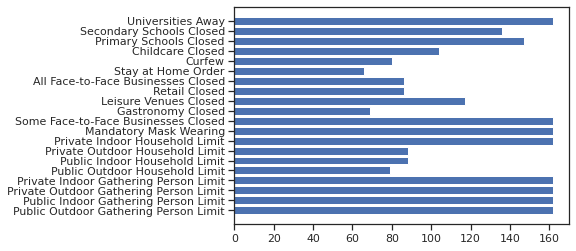

In [23]:
def count_active_days(npi):
    non_zero_rows = [ind for ind in range(df.shape[0]) if df[npi][ind] != 0]
    return len(np.unique(df['Date'][non_zero_rows]))
active_days = [count_active_days(npi) for npi in CMs]
plt.barh(y=CMs, width=active_days)

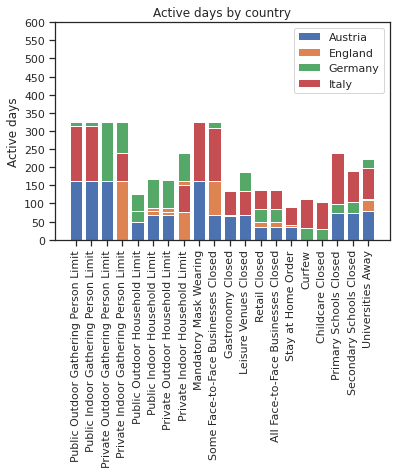

In [97]:
def count_active_days_country(npi):
    non_zero_rows = [ind for ind in range(df.shape[0]) if df[npi][ind] != 0]
    active_inds = []
    for country in np.unique(df['Country']):
        active_ind = [ind for ind in non_zero_rows if df['Country'][ind] == country]
        count = len(np.unique(df['Date'][active_ind]))
        active_inds.append(count)
    return active_inds
active_days_country = [count_active_days_country(npi) for npi in CMs]
active_days_country = pd.DataFrame.from_records(active_days_country)

plt.xticks(rotation=90)
ind = np.arange(len(CMs))
p1 = plt.bar(ind, active_days_country[0])
p2 = plt.bar(ind, active_days_country[1],
             bottom=active_days_country[0])
p3 = plt.bar(ind, active_days_country[2],
             bottom=active_days_country[1])
p4 = plt.bar(ind, active_days_country[3],
             bottom=active_days_country[2])
plt.ylabel('Active days')
plt.title('Active days by country')
plt.xticks(ind, CMs)
plt.yticks(np.arange(0, 4*162, 50))
plt.legend((p1[0], p2[0], p3[0], p4[0]), np.unique(df['Country']))

plt.show()

In [65]:
# def count_active_days_region(npi, country):
#     df_country = df[df['Country']==country]
#     non_zero_rows = [ind for ind in range(df_country.shape[0]) if df_country[npi][ind] != 0]
#     regions = np.unique(df_country['Area'])
#     active_inds = []
#     for region in regions:
#         active_ind = [ind for ind in non_zero_rows if df_country['Area'][ind] == region]
#         count = len(np.unique(df_country['Date'][active_ind]))
#         active_inds.append(count)
#     return regions, active_inds
#
# active_days_uk = [count_active_days_region(npi, 'England')[1] for npi in CMs]
# active_days_de = [count_active_days_region(npi, 'Germany')[1] for npi in CMs]
# active_days_at = [count_active_days_region(npi, 'Austria')[1] for npi in CMs]
# active_days_it = [count_active_days_region(npi, 'Italy')[1] for npi in CMs]

## Thresholding

want to isolate variables that tkae values different from 1.
- do unique greater than 2.
then want a chart that has a hist for each of 9 npis

Text(0.5, 0.98, 'Histogram of values (thresholds) for the relevant NPIs (includes 0 as a value)')

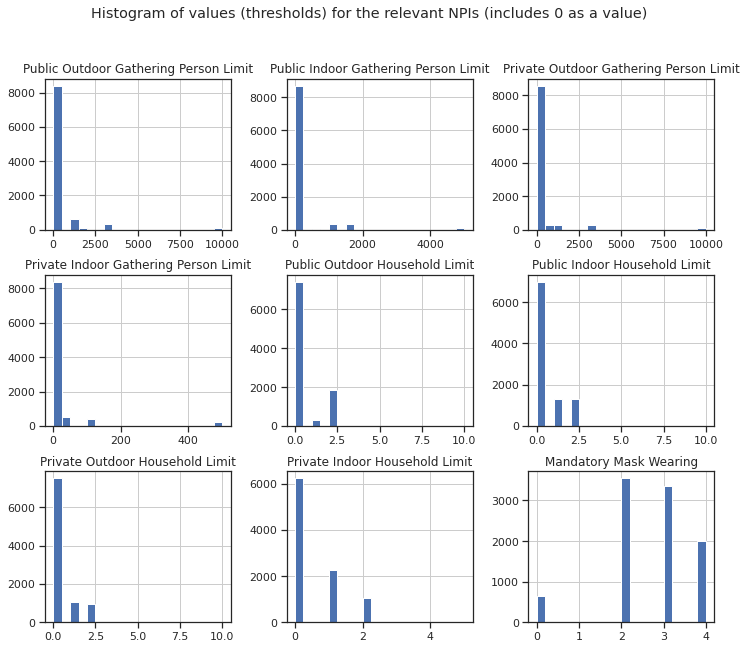

In [159]:
thresholding_CMs = [CM for CM in CMs if len(np.unique(df[CM]))>2]
#dataframe with only thresholidng npis
df.hist(column=thresholding_CMs, figsize=(12, 10), bins=20)
pl.suptitle("Histogram of values (thresholds) for the relevant NPIs (includes 0 as a value)")

Text(0.5, 0.98, 'Histogram of values (thresholds) for the relevant NPIs (excludes 0 as a value)')

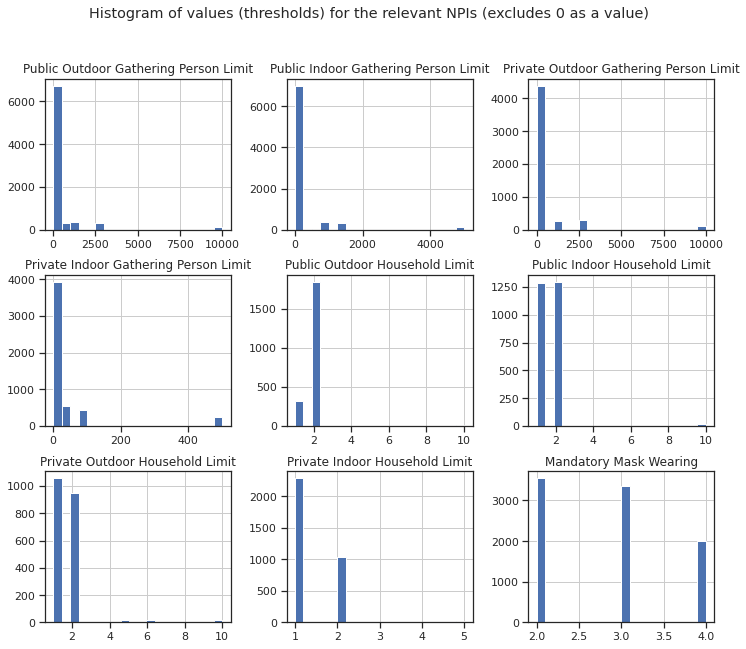

In [160]:
df_reduced = df[df!=0]
df_reduced.hist(column=thresholding_CMs, figsize=(12, 10), bins = 20)
pl.suptitle("Histogram of values (thresholds) for the relevant NPIs (excludes 0 as a value)")
#TODO: consider weighting by active days

## Conditional activation

for each pair of NPIs, how many days do we have where only one of them is active.
conditional activation matrix - of the proportion of time that NPI X was active, how often was NPI Y active.

In [149]:
def get_active_dates(npi):
    non_zero_dates = df['Date'][df[npi] != 0]
    return np.unique(non_zero_dates)

def intersect_npi_active_dates(npi_1, npi_2):
    return set(get_active_dates(npi_1)).intersection(set(get_active_dates(npi_2)))

def get_inactive_dates(npi):
    zero_dates = df['Date'][df[npi] == 0]
    return np.unique(zero_dates)

def proportional_activation(npi_1, npi_2):
    number_of_active_days = len(get_active_dates(npi_1))
    number_of_jointly_active_days = len(intersect_npi_active_dates(npi_1, npi_2))
    return number_of_jointly_active_days/number_of_active_days

# want a function that returns the number of days where only
# one is active, which is set(active_1) - set(active_2).
def activation_difference(npi_1, npi_2):
    return len(set(get_active_dates(npi_1)) - set(get_active_dates(npi_2)))

proportional_activations = np.zeros((len(CMs),len(CMs)))
activation_differences = np.zeros((len(CMs),len(CMs)))
for i in range(len(CMs)):
    for j in range(len(CMs)):
        proportional_activations[i, j] = proportional_activation(CMs[i], CMs[j])
        activation_differences[i, j] = activation_difference(CMs[i], CMs[j])

Text(0.5, 1.0, 'Conditional activation matrix: of the proportion of time that NPI X was active, how often was NPI Y active?')

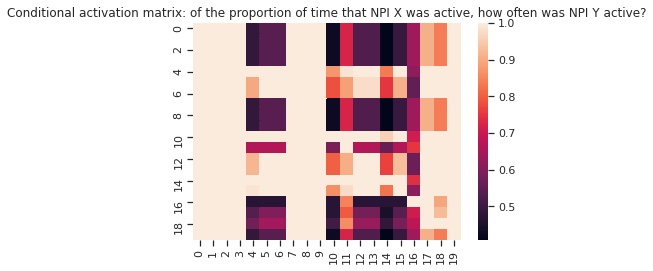

In [150]:
sns.heatmap(proportional_activations).set_title('Conditional activation matrix: of the proportion of time that NPI X was active, how often was NPI Y active?')

Text(0.5, 1.0, 'Number of days where only NPI X is active')

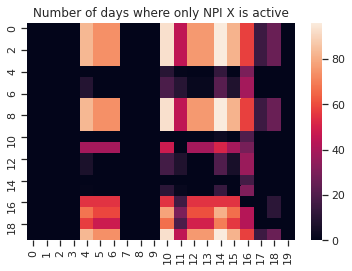

In [151]:
sns.heatmap(activation_differences).set_title('Number of days where only NPI X is active')

## Timeline plots